# BE/Bi 103, Fall 2016: Homework 4
## Due 1pm, Sunday, October 23

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw4.ipynb).*

In [1]:
import math

import numpy as np
import numba
import pandas as pd

import scipy.special
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

import corner

# Make Matplotlib plots appear inline
%matplotlib inline

### Problem 4.1: Writing your own MCMC sampler (60 pts + 40 pts extra credit)

**a)** Write your own MCMC sampler that employs a Metropolis-Hastings algorithm that uses a Gaussian proposal distribution. Since you are sampling multiple parameters, your proposal distribution will be multi-dimensional. You can use a Gaussian proposal distribution with a diagonal covariance. In other words, you generate a proposal for each variable in the posterior independently.

You can organize your code how you like, but here is a suggestion.

* Write a function that takes (or rejects) a Metropolis-Hastings step. It should look something like the below (obviously where it does something instead of `pass`ing).

In [2]:
def mh_step(x, logpost, logpost_current, sigma, args=()):
    """
    Parameters
    ----------
    x : ndarray, shape (n_variables,)
        The present location of the walker in parameter space.
    logpost : function
        The function to compute the log posterior. It has call
        signature `logpost(x, *args)`.
    logpost_current : float
        The current value of the log posterior.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    args : tuple
        Additional arguments passed to `logpost()` function.

    Returns
    -------
    output : ndarray, shape (n_variables,)
        The position of the walker after the Metropolis-Hastings
        step. If no step is taken, returns the inputted `x`.
    """
    
    pass

* Write another function that calls that function over and over again to do the sampling. It should look something like this:

In [3]:
def mh_sample(logpost, x0, sigma, args=(), n_burn=1000, n_steps=1000,
              variable_names=None):
    """
    Parameters
    ----------
    logpost : function
        The function to compute the log posterior. It has call
        signature `logpost(x, *args)`.
    x0 : ndarray, shape (n_variables,)
        The starting location of a walker in parameter space.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    args : tuple
        Additional arguments passed to `logpost()` function.
    n_burn : int, default 1000
        Number of burn-in steps.
    n_steps : int, default 1000
        Number of steps to take after burn-in.
    variable_names : list, length n_variables
        List of names of variables. If None, then variable names
        are sequential integers.
    
    Returns
    -------
    output : DataFrame
        The first `n_variables` columns contain the samples.
        Additionally, column 'lnprob' has the log posterior value
        at each sample.
    """
    
    pass

**b)** To test your code, we will get samples out of a known distribution. We will use a bivariate Gaussian with a mean of $\boldsymbol{\mu} = (10, 20)$ and covariance matrix of 

\begin{align}
\boldsymbol{\sigma} = \begin{pmatrix}
4 & -2 \\
-2 & 6
\end{pmatrix}
\end{align}

I have written the function to be unnormalized and JITted with numba for optimal speed.

Do not be confused: In this test function we are sampling $\mathbf{x}$. This is not sampling a posterior; it's just a test for your code. You will pass `log_test_distribution` as the `logpost` argument in the above functions.

In [4]:
mu = np.array([10.0, 20])
cov = np.array([[4, -2],[-2, 6]])
inv_cov = np.linalg.inv(cov)

@numba.jit(nopython=True)
def log_test_distribution(x, mu, inv_cov):
    """
    Unnormalized log posterior of a multivariate Gaussian.
    """
    return -np.dot((x-mu), np.dot(inv_cov, (x-mu))) / 2

If you compute the means and covariance (using `np.cov()`) of your samples, you should come close to the inputed means and covariance. You might also want to plot your samples using `corner.corner()` to make sure everything makes sense.

**c)** (20 pts extra credit) Add in some logic to your Metropolis-Hastings sampler to enable *tuning*. This is the process of automatically adjusting the $\sigma$ in the proposal distribution such that the acceptance rate is desirable. The target acceptance rate is about 0.4. The developers of [PyMC3](https://github.com/pymc-devs/pymc3) use the scheme below, which is reasonable.

|Acceptance rate|Standard deviation adaptation|
|:---:|:-------------------:|
| < 0.001        |$\times$ 0.1|
|< 0.05         |$\times$ 0.5|
|< 0.2          |$\times$ 0.9|
|> 0.5          |$\times$ 1.1|
|> 0.75         |$\times$ 2|
|> 0.95         |$\times$ 10|

Be sure to test your code to demonstrate that it works.

**d)** (20 pts extra credit) Either adapt the functions you already wrote or write new ones to enable sampling of discrete variables. Again, be sure to test your code.

### Problem 4.1: solution

I will complete part (a) and parts (c) and (d) together in defining my code. The tuning is done by choosing a *tuning interval*, the number of steps over which teh acceptance rate is average. If the tuning inverval is 100 steps, the $\sigma$ of the proposal distribution is adjusted every 100 steps.

Sampling discrete parameters is trickier because there are many type of discrete parameters. Here is a set of discrete parameter types and how we will sample them.

1. Parameter may have any integer value (possibly restricted to half the number line): Draw out of a tunable Gaussian proposal distribution and round the result.
2. Parameter may be one of a (usually small) set of values: Randomly choose among these values. This might result in large rejection rates.
3. Parameter may be one of a set of integers that is not too large. Here, we increment the integer plus or minus one at each sample.

There is the added wrinkle that sampling discrete parameters of type 2 on every step can lead to very low acceptance rates. For example, say a discrete variable could only take values zero or one and that zero is far more probable. When the walker is at zero, each proposal to move to one will be rejected over and over again. So, a better strategy is to take many steps in the continuous variables and then attempt a step by changing the discrete variable every now and then.

For simplicity in this example, we will consider only parameters of type 1. In this case, we can just sample the discrete parameters alongside the continuous ones. There is a trick in defining the proposal distribution. I will choose a Gaussian proposal distribution where we round the result. In this case, for discrete parameter $a_i$,

\begin{align}
K(a_i \mid a_{i+1}) &= \frac{1}{\sqrt{2\pi\sigma^2}}\,\int_{a_i-1/2}^{a_i+1/2}\mathrm{d}a_i'\,\exp\left[-\frac{(a_i' - a_{i+1})^2}{2\sigma^2}\right] \\[1em]
&= \frac{1}{2}\left[\mathrm{erf}\left(\frac{1+2(a_{i+1}-a_i)}{\sqrt{8\sigma^2}}\right) + \mathrm{erf}\left(\frac{1+2(a_i-a_{i+1})}{\sqrt{8\sigma^2}}\right)\right],
\end{align}

which has the symmetry property that $K(a_i \mid a_{i+1}) = K(a_{i+1} \mid a_i)$, which is the case for a Gaussian proposal distribution without rounding. So, in all cases, we can ignore the proposal distributions when computing the Metropolis ratio.

In [21]:
def adjust_sigma(acc_rate, sigma):
    """
    Tune sigma in proposal distribution.
    
    Parameters
    ----------
    acc_rate : float
        The acceptance rate.
    sigma : ndarray
        Array of standard deviations for Gaussian proposal 
        distribution.

    Returns
    -------
    output : ndarray
        Updated `sigma` values.
    """
    if acc_rate < 0.001:
        return sigma * 0.1
    elif acc_rate < 0.05:
        return sigma * 0.5
    elif acc_rate < 0.2:
        return sigma * 0.9
    elif acc_rate > 0.95:
        return sigma * 10.0
    elif acc_rate > 0.75:
        return sigma * 2.0
    elif acc_rate > 0.5:
        return sigma * 1.1
    else:
        return sigma
    
    
def mh_step(x, logpost, logpost_current, sigma, discrete, args=()):
    """
    Parameters
    ----------
    x : ndarray, shape (n_variables,)
        The present location of the walker in parameter space.
    logpost : function
        The function to compute the log posterior. It has call
        signature `logpost(x, *args)`.
    logpost_current : float
        The current value of the log posterior.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    discrete : ndarray of bools, shape (n_variables,)
        discrete[i] is True if variable i is discrete and False
        otherwise. If None (default), all entries are False.
    args : tuple
        Additional arguments passed to `logpost()` function.

    Returns
    -------
    output : ndarray, shape (n_variables,)
        The position of the walker after the Metropolis-Hastings
        step. If no step is taken, returns the inputted `x`.
    """
    # Draw the next step
    x_next = np.empty(len(x), dtype=x.dtype)
    for i, x_val in enumerate(x):
        if discrete[i]:
            x_next[i] = np.round(np.random.normal(x[i], sigma[i]))
        else:
            x_next[i] = np.random.normal(x[i], sigma[i])

    # Compute log posterior
    logpost_new = logpost(x_next, *args)

    # Compute the log Metropolis ratio
    log_r = logpost_new - logpost_current

    # Accept or reject step
    if log_r >= 0 or np.random.random() < np.exp(log_r):
        return x_next, logpost_new, True
    else:
        return x, logpost_current, False    


def mh_sample(logpost, x0, sigma=None, discrete=None, args=(), n_burn=1000, 
              n_steps=1000, tune_interval=100, variable_names=None, 
              return_acceptance_rate=False):
    """
    Parameters
    ----------
    logpost : function
        The function to compute the log posterior. It has call
        signature `logpost(x, *args)`.
    x0 : ndarray, shape (n_variables,)
        The starting location of a walker in parameter space.
    sigma : ndarray, shape (n_variables,)
        The standard deviations for the proposal distribution.
        If None, takes all values to be one.
    discrete : ndarray of bools, shape (n_variables,)
        discrete[i] is True if variable i is discrete and False
        otherwise. If None (default), all entries are False.
    args : tuple
        Additional arguments passed to `logpost()` function.
    n_burn : int, default 1000
        Number of burn-in steps.
    n_steps : int, default 1000
        Number of steps to take after burn-in.
    tune_interval : int, default 100
        Number of steps to use when determining acceptance
        fraction for tuning.
    variable_names : list, length n_variables
        List of names of variables. If None, then variable names
        are sequential integers.
    return_acceptance_rate : bool, default False
        If True, also return acceptance rate.
    
    Returns
    -------
    output : DataFrame
        The first `n_variables` columns contain the samples.
        Additionally, column 'lnprob' has the log posterior value
        at each sample.
    """
    # Use default indices for variable names
    if variable_names is None:
        variable_names = list(range(len(x0)))
        
    # Set sigma to be default if not provided
    if sigma is None:
        sigma = np.ones(len(x0))
        
    # Default to continuous variables
    if discrete is None:
        discrete = np.array([False]*len(x0))
    else:
        discrete = np.array(discrete)
                            
    # Grab the samples in a NumPy array
    x_samples, lnprob, acc_rate = _metropolis_sample(
            x0, logpost, sigma, discrete, n_burn, n_steps, 
            tune_interval=tune_interval, args=args)

    df = pd.DataFrame(columns=variable_names, data=x_samples)
    df['lnprob'] = lnprob
    
    if return_acceptance_rate:
        return df, acc_rate
    return df


def _metropolis_sample(x0, logpost, sigma, discrete, n_burn, n_steps,
                       tune_interval=100, args=()):
    """
    Parameters
    ----------
    x0 : ndarray, shape (n_variables,)
        The starting location of a walker in parameter space.
    logpost : function
        The function to compute the log posterior. It has call
        signature `logpost(x, *args)`.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
        If None, takes all values to be one.
    discrete : ndarray of bools, shape (n_variables,)
        discrete[i] is True if variable i is discrete and False
        otherwise. If None (default), all entries are False.
    n_burn : int, default 1000
        Number of burn-in steps.
    n_steps : int, default 1000
        Number of steps to take after burn-in.
    tune_interval : int, default 100
        Number of steps to use when determining acceptance
        fraction for tuning.
    args : tuple
        Additional arguments passed to `logpost()` function.
    
    Returns
    -------
    x_samples : ndarray, shape(n_steps, len(x0))
        Numpy array of samples. Each column corresponds to
        one variable.
    lnprob: ndarray, shape(n_steps)
        The log probability of the sampled distribution at
        each step.
    acceptance_rate : float
        The fraction of proposed steps that were taken.
    """
    # Never tune if asked not to
    if tune_interval <= 0:
        tune_interval = n_burn + n_steps
    elif tune_interval < 50:
        raise RuntimeError('Tune interval should be at least 50.')


    # Initialize
    x = np.copy(x0)
    n_accept = 0
    n_accept_total = 0
    n = 0
    n_tune_steps = 0
    n_continuous_steps = 0
    lnprob = np.empty(n_steps)
    logpost_current = logpost(x, *args)

    # Burn in
    while n < n_burn:
        while n_tune_steps < tune_interval and n < n_burn:
            x, logpost_current, accept = mh_step(
                        x, logpost, logpost_current, sigma, discrete, args)
            n += 1
            n_tune_steps += 1
            n_accept += accept
        sigma = adjust_sigma(n_accept/tune_interval, sigma)
        n_accept = 0
        n_tune_steps = 0

    # Samples
    x_samples = np.empty((n_steps, len(x)))
    n = 0
    while n < n_steps:
        while n_tune_steps < tune_interval and n < n_steps:
            x, logpost_current, accept = mh_step(
                        x, logpost, logpost_current, sigma, discrete, args)
            x_samples[n,:] = x
            lnprob[n] = logpost_current
            n_tune_steps += 1
            n_accept += accept
            n_accept_total += accept
            n += 1
        sigma = adjust_sigma(n_accept/tune_interval, sigma)
        n_accept = 0
        n_tune_steps = 0
        
    return x_samples, lnprob, n_accept_total/n_steps

**b)** We first test out sampler with the test distribution provided in the problem statement.  We'll take 500,000 steps and give an initial starting point of the walk that is a bit off from the MAP just to give the MCMC walker a little extra work to do.

In [22]:
# Set up inputs
args = (mu, inv_cov)
x0 = np.array([7.0, 30.0])

# Run solver
df, acc_rate = mh_sample(
    log_test_distribution, x0, sigma=None, discrete=[False, False], 
    args=args, n_burn=500000, n_steps=500000, tune_interval=100, 
    variable_names=['x1', 'x2'], return_acceptance_rate=True)

Let's see how we did on the acceptance rate.

In [23]:
acc_rate

0.347858

Pretty good. We managed to tune the solver well. Let's check to see if we got the right values for $\mu$, $\sigma$, and the covariance.

In [24]:
print('µ1 =', np.mean(df['x1']), '\n')
print('µ2 =', np.mean(df['x2']), '\n')
print('covariance:')
np.cov(df.loc[:,'x1'], df.loc[:,'x2'])

µ1 = 9.995022298589745 

µ2 = 20.008520574156762 

covariance:


array([[ 4.01181302, -2.00317721],
       [-2.00317721,  5.9657741 ]])

Looks very close to what we expect. Now let's make a corner plot.

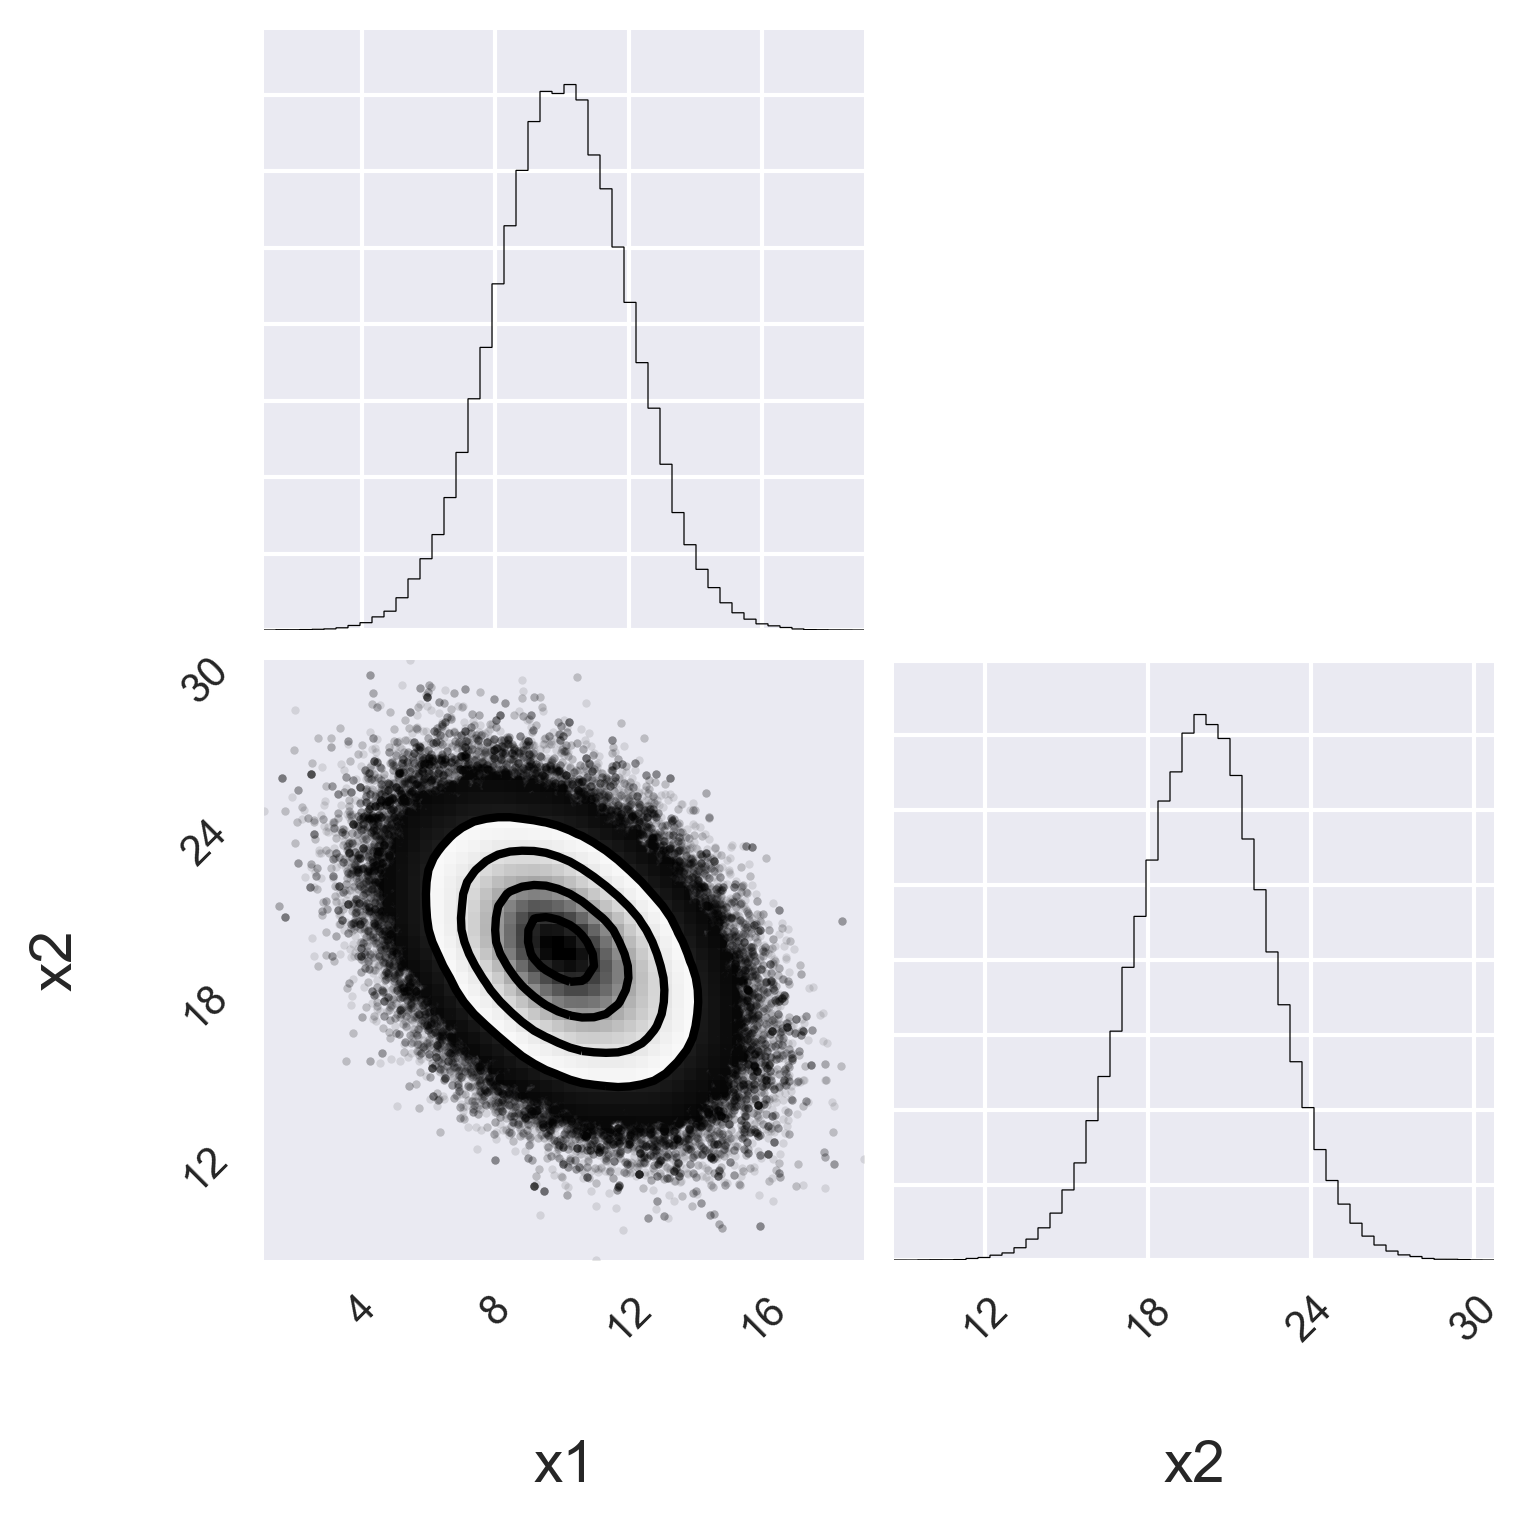

In [25]:
corner.corner(df[['x1', 'x2']], bins=50, labels=['x1', 'x2'], smooth=1);

This is exactly as we would expect. Very nice!

Now, let's try sampling a discrete distribution. We'll start by testing it out by sampling out of a Binomial distribution. This is a univariate sampling problem. We already have our log distribution coded up for us; it's `scipy.stats.binom.logpmf()`.

In [26]:
# Set up inputs
args = (20, 0.3) # n, p
x0 = np.array([3])

# Run solver
df, acc_rate = mh_sample(
    st.binom.logpmf, x0, sigma=None, discrete=[True], 
    args=args, n_burn=500000, n_steps=500000, tune_interval=100, 
    variable_names=['k'], return_acceptance_rate=True)

Now, we can plot the PMF.

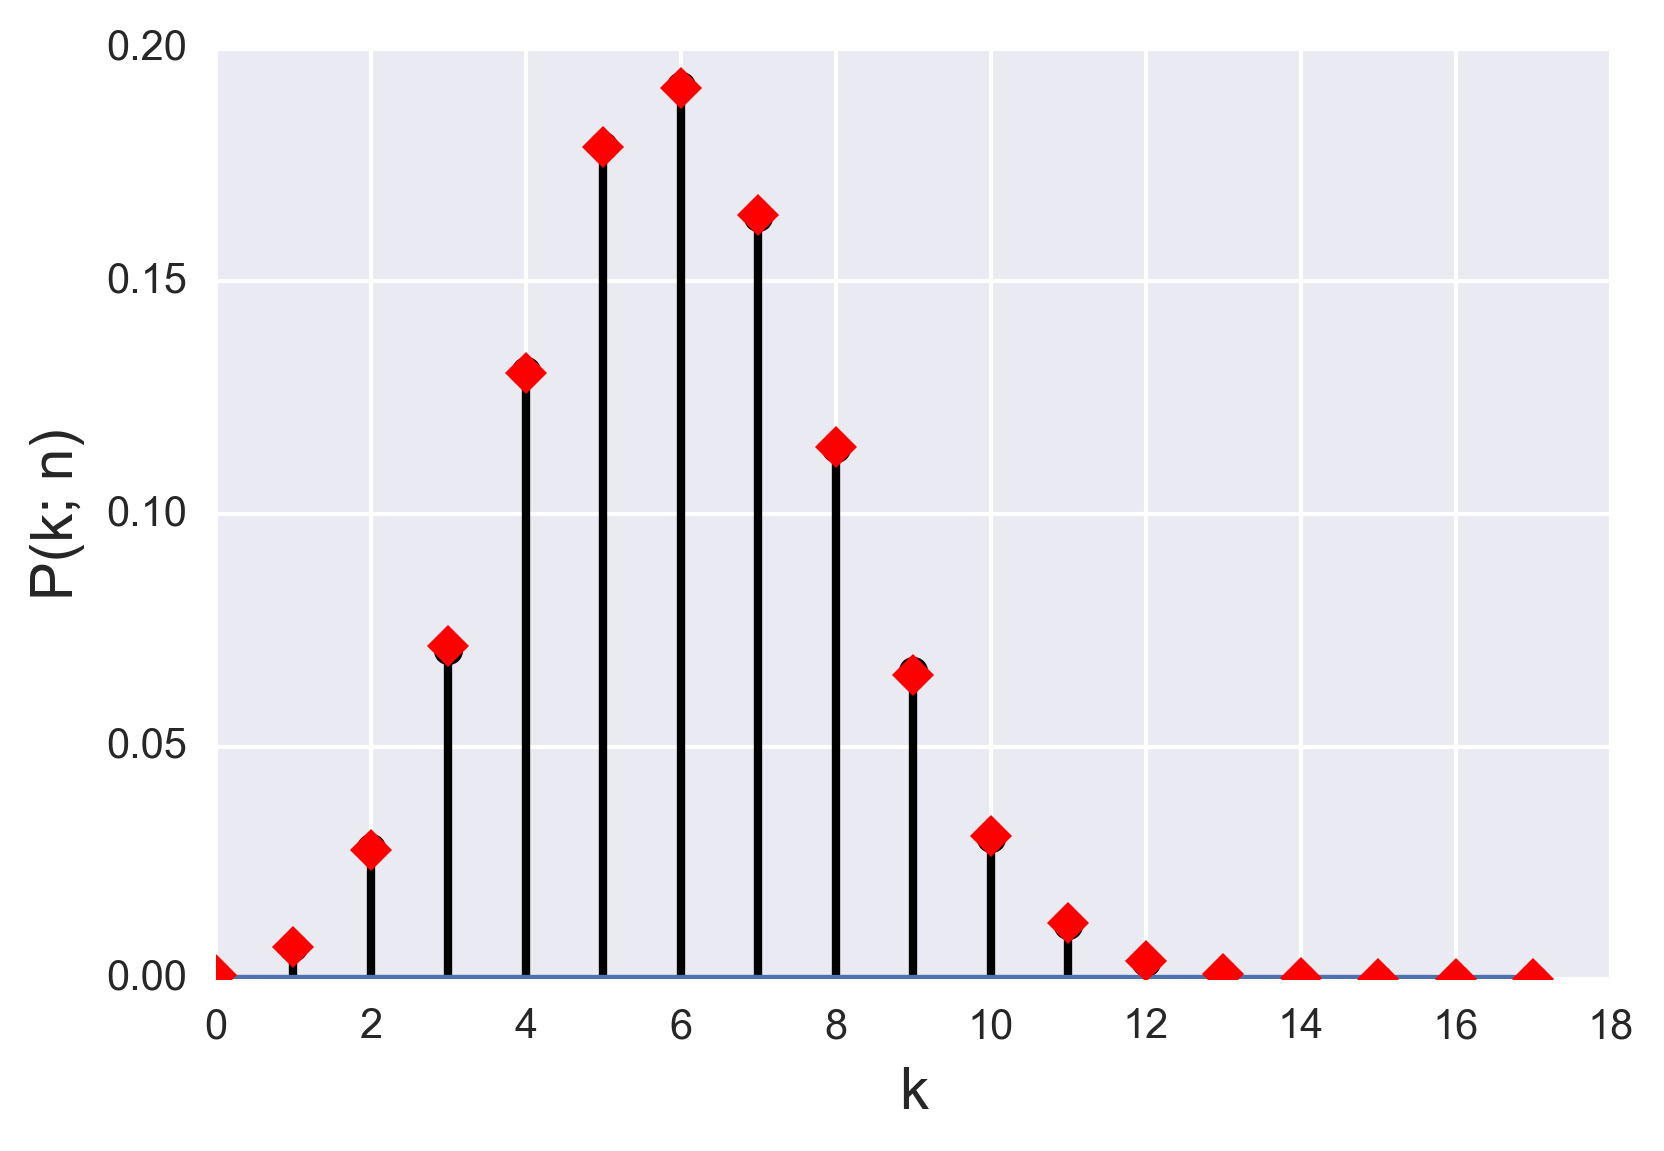

In [27]:
# Convert to integers
df['k'] = df['k'].astype(int)

# Count how many times each integer was encountered
pmf = np.bincount(df['k']) / len(df)

# Plot the PMF
plt.stem(np.arange(len(pmf)), pmf, linefmt='k', markerfmt='ko', basefmt='')

# Plot theoretical PMF
plt.plot(np.arange(len(pmf)), st.binom.pmf(np.arange(len(pmf)), *args), 'rD')

# Label axes
plt.xlabel('k')
plt.ylabel('P(k; n)');

So, the sampler worked well!

Now, we can get major speed boosts by Numba-ing everything. As a basis for comparison, let's see how long it takes to get our 500,000 (plus 500,000 burn in) with the sampler as written.

In [28]:
args = (mu, inv_cov)
x0 = np.array([7.0, 30.0])
%timeit mh_sample(log_test_distribution, x0, sigma=None, discrete=[False, False], args=args, n_burn=500000, n_steps=500000, tune_interval=100,  variable_names=['µ', 'σ'])

1 loop, best of 3: 9.2 s per loop


Now, we'll Numba everything. We have to take care because we cannot pass functions into Numba'd functions in `nopython` mode. To get around this, we put the functions that do the samping within a wrapper that takes an input a numba'd log posterior function. Yes, the log posterior function must also be Numba'd in `nopython` mode.

In [32]:
@numba.jit(nopython=True)
def adjust_sigma(acc_rate, sigma):
    """
    Tune sigma in proposal distribution.
    
    Parameters
    ----------
    acc_rate : float
        The acceptance rate.
    sigma : ndarray
        Array of standard deviations for Gaussian proposal 
        distribution.

    Returns
    -------
    output : ndarray
        Updated `sigma` values.
    """
    if acc_rate < 0.001:
        return sigma * 0.1
    elif acc_rate < 0.05:
        return sigma * 0.5
    elif acc_rate < 0.2:
        return sigma * 0.9
    elif acc_rate > 0.95:
        return sigma * 10.0
    elif acc_rate > 0.75:
        return sigma * 2.0
    elif acc_rate > 0.5:
        return sigma * 1.1
    else:
        return sigma
    

def mh_sample(logpost, x0, sigma=None, discrete=None, args=(), n_burn=1000, 
              n_steps=1000, tune_interval=100, variable_names=None, 
              return_acceptance_rate=False):
    """
    Parameters
    ----------
    logpost : function
        The function to compute the log posterior. It has call
        signature `logpost(x, *args)`.
    x0 : ndarray, shape (n_variables,)
        The starting location of a walker in parameter space.
    sigma : ndarray, shape (n_variables,)
        The standard deviations for the proposal distribution.
        If None, takes all values to be one.
    discrete : ndarray of bools, shape (n_variables,)
        discrete[i] is True if variable i is discrete and False
        otherwise. If None (default), all entries are False.
    args : tuple
        Additional arguments passed to `logpost()` function.
    n_burn : int, default 1000
        Number of burn-in steps.
    n_steps : int, default 1000
        Number of steps to take after burn-in.
    tune_interval : int, default 100
        Number of steps to use when determining acceptance
        fraction for tuning.
    variable_names : list, length n_variables
        List of names of variables. If None, then variable names
        are sequential integers.
    return_acceptance_rate : bool, default False
        If True, also return acceptance rate.
    
    Returns
    -------
    output : DataFrame
        The first `n_variables` columns contain the samples.
        Additionally, column 'lnprob' has the log posterior value
        at each sample.
    """
    
    @numba.jit(nopython=True)
    def mh_step(x, logpost_current, sigma, discrete, args=()):
        """
        Parameters
        ----------
        x : ndarray, shape (n_variables,)
            The present location of the walker in parameter space.
        logpost_current : float
            The current value of the log posterior.
        sigma : ndarray, shape (n_variables, )
            The standard deviations for the proposal distribution.
        discrete : ndarray of bools, shape (n_variables,)
            discrete[i] is True if variable i is discrete and False
            otherwise. If None (default), all entries are False.
        args : tuple
            Additional arguments passed to `logpost()` function.

        Returns
        -------
        output : ndarray, shape (n_variables,)
            The position of the walker after the Metropolis-Hastings
            step. If no step is taken, returns the inputted `x`.
        """
        # Draw the next step
        x_next = np.empty(len(x), dtype=x.dtype)
        for i, x_val in enumerate(x):
            if discrete[i]:
                x_next[i] = np.round(np.random.normal(x[i], sigma[i]))
            else:
                x_next[i] = np.random.normal(x[i], sigma[i])

        # Compute log posterior
        logpost_new = logpost(x_next, *args)

        # Compute the log Metropolis ratio
        log_r = logpost_new - logpost_current

        # Accept or reject step
        if log_r >= 0 or np.random.random() < np.exp(log_r):
            return x_next, logpost_new, True
        else:
            return x, logpost_current, False    

        # Never tune if asked not to
        if tune_interval <= 0:
            tune_interval = n_burn + n_steps
        elif tune_interval < 50:
            raise RuntimeError('Tune interval should be at least 50.')

            
    @numba.jit(nopython=True)
    def _metropolis_sample(x0, sigma, discrete, n_burn, n_steps,
                           tune_interval=100, args=()):
        """
        Numba'd sampler.
        """

        # Initialize
        x = np.copy(x0)
        n_accept = 0
        n_accept_total = 0
        n = 0
        n_tune_steps = 0
        n_continuous_steps = 0
        lnprob = np.empty(n_steps)
        logpost_current = logpost(x, *args)

        # Burn in
        while n < n_burn:
            while n_tune_steps < tune_interval and n < n_burn:
                x, logpost_current, accept = mh_step(
                            x, logpost_current, sigma, discrete, args)
                n += 1
                n_tune_steps += 1
                n_accept += accept
            sigma = adjust_sigma(n_accept/tune_interval, sigma)
            n_accept = 0
            n_tune_steps = 0

        # Samples
        x_samples = np.empty((n_steps, len(x)))
        n = 0
        while n < n_steps:
            while n_tune_steps < tune_interval and n < n_steps:
                x, logpost_current, accept = mh_step(
                            x, logpost_current, sigma, discrete, args)
                x_samples[n,:] = x
                lnprob[n] = logpost_current
                n_tune_steps += 1
                n_accept += accept
                n_accept_total += accept
                n += 1
            sigma = adjust_sigma(n_accept/tune_interval, sigma)
            n_accept = 0
            n_tune_steps = 0

        return x_samples, lnprob, n_accept_total/n_steps

    # Use default indices for variable names
    if variable_names is None:
        variable_names = list(range(len(x0)))
        
    # Set sigma to be default if not provided
    if sigma is None:
        sigma = np.ones(len(x0))
        
    # Default to continuous variables
    if discrete is None:
        discrete = np.array([False]*len(x0))
    else:
        discrete = np.array(discrete)
                            
    # Grab the samples in a NumPy array
    x_samples, lnprob, acc_rate = _metropolis_sample(
            x0, sigma, discrete, n_burn, n_steps, 
            tune_interval=tune_interval, args=args)

    df = pd.DataFrame(columns=variable_names, data=x_samples)
    df['lnprob'] = lnprob
    
    if return_acceptance_rate:
        return df, acc_rate
    return df

First, let's do a quick check to make sure we get the same results.

In [33]:
# Run solver
df, acc_rate = mh_sample(
    log_test_distribution, x0, sigma=None, discrete=[False, False], 
    args=args, n_burn=500000, n_steps=500000, tune_interval=100, 
    variable_names=['x1', 'x2'], return_acceptance_rate=True)

print('µ1 =', np.mean(df['x1']), '\n')
print('µ2 =', np.mean(df['x2']), '\n')
print('covariance:')
np.cov(df.loc[:,'x1'], df.loc[:,'x2'])

µ1 = 10.008159373405151 

µ2 = 19.99705261193958 

covariance:


array([[ 3.99028253, -2.01076942],
       [-2.01076942,  6.00648217]])

Looks good! Now, let's time it!

In [34]:
%timeit mh_sample(log_test_distribution, x0, sigma=None, discrete=[False, False], args=args, n_burn=500000, n_steps=500000, tune_interval=100,  variable_names=['µ', 'σ'])

1 loop, best of 3: 1.67 s per loop


That's over a factor of 5 speed boost. There are other ways we can speed this up, by tailoring the functions for different input types, but by making a few small tweaks and JITting, we get a factor of five. We'll use this numba'd version for problem 4.2.

<br />

### Problem 4.2: MCMC with Boolean data (40 pts)

In this problem, we will work with data of the True/False type. Lots of data sets in the biological sciences are like this. For example, we might look at a certain mutation in *Drosophila* that affects development and we might check whether or not eggs hatch.

The data we will use comes from an experiment we did the last couple years in [Bi 1x](http://bi1x.caltech.edu/) here at Caltech. The experiment was developed by Meaghan Sullivan. We studies a neural circuit in *C. elegans* using optogenetics.

A neural circuit is a series of interconnected neurons that create a pathway to transmit a signal from where it is received, to where it causes a behavioral response in an animal.  An example is the neural circuit involved in reversals in *C. elegans*.  This circuit consists of three types of neurons: sensory neurons receive stimuli from the environment, command interneurons integrate information from many sensory neurons and pass a signal to the motor neurons, and motor neurons control worm behavior, such as reversals.

There are six neurons acting in a circuit that responds to environmental cues and triggers a reversal, a shown in the figure below (based on [Schultheis et. al. 2011](10.1371/journal.pone.0018766)).  These include four sensory neurons (ALM, AVM, ASH, and PLM).  Each sensory neuron is sensitive to a different type of stimulus.  For example, the sensory neuron we are studying (ASH) is sensitive to chemosensory stimuli such as toxins, while another neuron (PLM) is sensitive to mechanical stimuli (touch) in the posterior part of the worm's body.  The sensory neurons send signals that are integrated by two command interneurons (AVA and AVD).  Each sensory neuron can provide an impulse to the command interneurons at any time.  In order for the command interneuron to fire and activate motor neurons, the sum of the stimuli at any point in time must exceed a certain threshold.  Once the stimuli from one or more sensory neurons has induced an action potential in a command interneuron, that signal is passed to motor neurons which will modulate worm behavior.

![Reversal neural network](reversal_neural_network.png)

In the experiment, we used optogenetics to dissect the function of individual neurons in this circuit.  We worked with two optogenetic worm strains.  The ASH strain has channelrhodopsin (ChR2, represented by a red barrel in the figure above) expressed only in the ASH sensory neuron.  When we shine blue light on this strain, we should activate the ChR2, which will allow sodium and calcium cations to flow into the neuron, simulating an action potential. We want to quantify how robustly this stimulation will cause the worm to exhibit aversion behavior and reverse.  

We also studied an AVA strain that has channelrhodopsin expressed only in the AVA command interneuron.  Our goal is to quantify the effects of stimulating this neuron in terms of reversals compared to the ASH neuron and to wild type.

The True/False data here are the whether or not the worms undergo a reversal. Here is what the students observed.

|Strain|Year|Trials|Reversals|
|:---:|:---:|:---:|:---:|
|WT|2016|36|6|
|ASH|2016|35|12|
|AVA|2016|36|30|
|WT|2015|35|0|
|ASH|2015|35|9|
|AVA|2015|36|33|

For the purposes of this problem, assume that we can pool the results from the two years to have 6/71 reversals for wild type, 21/70 reversals for ASH, and 63/72 reversals for AVA.

Our goal is to estimate $p$, the probability of reversal for each strain. That is to say, we want to compute $P(p\mid r, n, I)$, where $r$ is the number of reversals in $n$ trials.

**a)** Write down an expression for the posterior distribution. That is, write down an expression for the likelihood and prior. You can actually compute the evidence analytically, but that is not necessary for this problem; you can just write down the likelihood and prior.

**b)** Use your Metropolis-Hastings sampler to sample this posterior for $p$ for each of the three strains. If you were unable to compute problem 3.1, you may use `emcee` to do the sampling. Plot the results. Do you think there is a difference between the wild type and ASH? How about between ASH and AVA?

**c)** The posterior plots from part **(b)** are illuminating, but suppose we want to quantify *the difference* in reversal probability between the two strains, say strain 1 and strain 2.  That is, we want to compute $P(\delta\mid D, I)$, where $\delta \equiv p_2 - p_1$. Use MCMC to compute this, employing your Metropolis-Hastings solver if you can, using `emcee` otherwise.

After you have done that with MCMC, it is useful to look at what a pain it is to attempt it analytically. I am just showing this as a lesson to you. To compute the distribution $P(\delta\mid D, I)$, we use the fact that we can easily compute the joint probability distribution because the two strains are independent.  To ease notation, we will note that the prior $P(p_1, p_2\mid I)$ is only nonzero if $0\le p_1,p_2 \le 1$, instead of writing it explicitly.  The posterior is

\begin{align}
P(p_1, p_2\mid D, I) &= 
\frac{(n_1+1)!\,(n_2+1)!}{(n_1-n_{r1})!\,n_{r1}!\,(n_2 - n_{r2})!\,n_{r2}!} \\[0.5em]
&\;\;\;\;\;\;\;\;\times\,p_1^{n_{r1}}\,(1-p_1)^{n_1-n_{r1}}\,p_2^{n_{r2}}\,(1-p_2)^{n_2-n_{r2}}.
\end{align}

We can define new variables $\delta = p_2 - p_1$ and $\gamma = p_1 + p_2$.  Then, we have $p_1 = (\gamma - \delta) / 2$ and $p_2 = (\gamma + \delta) / 2$. 
Again, to ease notation, we note that $P(\gamma, \delta\mid D, I)$ is nonzero only when $-1 \le \delta \le 1$ and $|\delta| \le \gamma \le 2 - |\delta|$.  By the change of variables formula for probability distributions we have

\begin{align}
P(\gamma, \delta \mid D, I) =
\begin{vmatrix}
\mathrm{d}p_1/\mathrm{d}\gamma & \mathrm{d}p_1/\mathrm{d}\delta \\
\mathrm{d}p_2/\mathrm{d}\gamma & \mathrm{d}p_2/\mathrm{d}\delta
\end{vmatrix}
P(p_1, p_2 \mid n_{r1}, n_{r2}, n_1, n_2, I)
= \frac{1}{2}\,P(p_1, p_2 \mid D, I).
\end{align}

Thus, we have

\begin{align}
P(\gamma, \delta\mid D, I) &= \frac{(n_1+1)!\,(n_2+1)!}{2(n_1-n_{r1})!\,(n_2-n_{r2})!\,n_1!\,n_2!} \\
&\;\;\;\;\times 
\left(\frac{\gamma-\delta}{2}\right)^{n_{r1}}\,\left(1-\frac{\gamma-\delta}{2}\right)^{n_1-n_{r1}} \left(\frac{\gamma+\delta}{2}\right)^{n_{r2}}\,\left(1-\frac{\gamma+\delta}{2}\right)^{n_2-n_{r2}}.
\end{align}

Finally, to find $P(\delta\mid D, I)$, we marginalize by integrating over all possible values of $\gamma$.

\begin{align}
P(\delta\mid D, I) =
\int_{|\delta|}^{2-|\delta|}\mathrm{d}\gamma\, P(\gamma, \delta\mid D, I)
\end{align}

We can expand each of the multiplied terms in the integrand into a polynomial using the binomial theorem, and can then multiply the polynomials together to get a polynomial expression for the integrand.  This can then be integrated.  There is a technical term describing this process: *a big mess*. Ouch. *This* is a major motivation for using MCMC!

### Problem 4.2: solution

**a)** Our goal is to estimate the probability of reversal, given an observed sequence of trials wherein the worm either reverses or does not.  The probability of reversal is a parameter in a model, and we need to derive the appropriate likelihood and prior for this model.  Remember, we want to find the posterior

\begin{align}
P(p\mid D, I) = \frac{P(D\mid p, I)\,P(p \mid I)}{P(D \mid I)}.
\end{align}

#### The likelihood
Let's start with the likelihood.  We will build an expression for $P(D\mid p, I)$.  First, what is $D$?  $D$ is the list of the results of all trials for a given strain.  If we assume that each trial is independent of all others, then the order of the trials does not matter.  We then only need to consider the number of reversals and the total number of trials.  We will define these quantities to be $r$ and $n$, respectively.

Now, what is $P(r \mid n, p, I)$?  Imagine that trail number 1 showed a reversal.  The probability that this happens is $p$.  Now, imagine that trail number 2 also showed a reversal.  The probability that trials 1 and 2 went this way is $p^2$, since the trials are independent.  Now, imagine trial 3 did not show a reversal.  The probability of trails 1, 2, and 3 going this way is $p^2(1-p)$, since the probability of *not* showing a reversal is $1-p$.  So, we can see that a *given sequence* of $n$ trails that show $r$ reversals occurs with probability $p^{r}(1-p)^{n-r}$.  But, this is just one of many sets of trials that can occur with $r$ reversals.  How many ways are there to have $r$ out of $n$ reversals?  The answer is given by the **binomial coefficient**.

\begin{align}
\begin{pmatrix}
n \\ r
\end{pmatrix} = \frac{n!}{r!\,(n-r)!},
\end{align}

pronounced "$n$ choose $r$."  So, our likelihood is given by the **binomial distribution**,

\begin{align}
P(r \mid n, p, I) = \frac{n!}{r!\,(n-r)!} p^{r}(1-p)^{n-r}.
\end{align}

(We could also have just looked up the story, but I just reasoned how the story comes about.) With our new representation of $D$, we can re-write the posterior as

\begin{align}
P(p\mid r, n, I) = \frac{P(r \mid n, p, I)\,P(p \mid n, I)}{P(r \mid n, I)}.
\end{align}


#### The prior
The prior distribution is what we know about the worm before any trials.  We will assume we know nothing.  So, there is equal probability that $p$ takes any value between zero and one, so

\begin{align}
P(p\mid n, I) = \left\{ \begin{array}{ccc}
1 & & 0 \le p \le 1 \\
0 & & \text{otherwise}.
\end{array}\right.
\end{align}

#### The evidence
Finally, $P(r\mid n, I)$ does not matter to us because it does not depend on $p$ (the thing we are trying to find out), and it is only a constant of proportionality determined by the fact that the posterior distribution must be normalized.  But, since we can calculate it in this case, I will go ahead and do it.

We can use our intuition about $P(r\mid n, I)$ to evaluate an otherwise difficult integral for the normalization constant.  Remember that $P(r \mid n, I)$ is the probability distribution for the number of reversals knowing nothing about the worm.  In this case, all possible numbers of reversals in $n$ trials should be equally likely.  Because we could see zero reversals, there are $n+1$ possibilities.  So, $P(r\mid n, I) = 1/(n+1)$.  We then have our normalized posterior,

\begin{align}
P(p\mid r, n, I) = \left\{ \begin{array}{ccc}
{\displaystyle \frac{(n+1)!}{(n-r)!\,r!}\,p^{r}(1-p)^{n-r}} & & 0 \le p \le 1 \\[1em]
0 & & \text{otherwise}.
\end{array}\right.
\end{align}

So, we are done.  We have an analytical expression for our posterior!  We need only to know the number of reversals, $r$ out of $n$ trials. Since we have the analytical result and it is easy to plot, I'll go ahead and do it.

Next, we'll write a function to compute the posterior.  We have to be careful, as usual, and compute the log of the posterior first and then exponentiating.  This avoids over and underflow errors.  In particular, we need to compute the logarithms of factorials.  It is useful to know that $n! = \Gamma(n+1)$, where $\Gamma(x)$ denotes the gamma function.  There is a convenient function to computing the logarithm of the gamma function, `scipy.special.gammaln()`.

In [35]:
def log_posterior(p, n, r):
    """
    Log posterior of reversal measurements.
    """
    return scipy.special.gammaln(n+2) - scipy.special.gammaln(r + 1) \
              - scipy.special.gammaln(n - r + 1) \
              + r * np.log(p) + (n - r) * np.log(1 - p)

Now, we'll specify our data set as a `DataFrame`.

In [36]:
data = [['WT', 71, 6],
        ['ASH', 70, 21],
        ['AVA', 73, 63]]

df = pd.DataFrame(columns=['strain', 'n', 'r'], data=data)

Now, we can make our plots.

/Users/Justin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


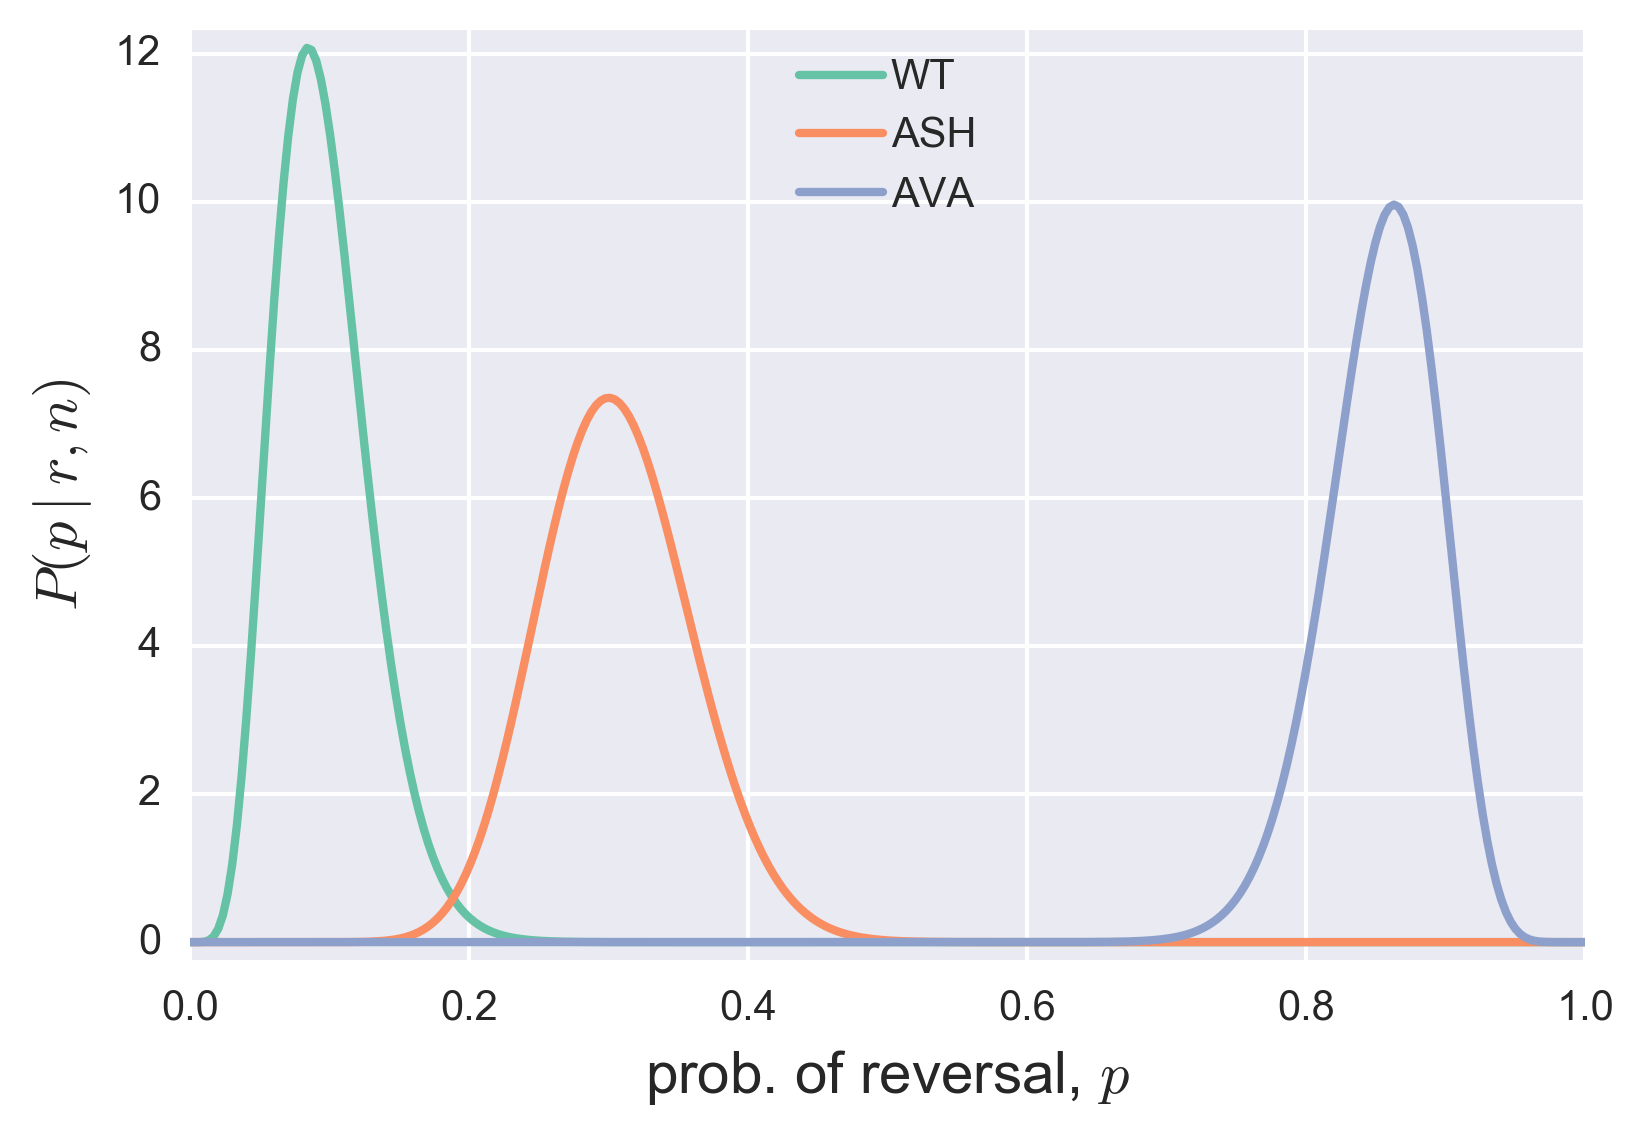

In [37]:
# Values of p for plot
p = np.linspace(0, 1, 300)

# Colors
colors = sns.color_palette("Set2", 10)

# Make plots
strains = ['WT', 'ASH', 'AVA']  
for i, strain in enumerate(df['strain']):
    n, r = df.loc[df['strain']==strain, ['n', 'r']].values.flatten()
    y = np.exp(log_posterior(p, n, r))
    plt.plot(p, np.exp(log_posterior(p, n, r)), color=colors[i])

# Pretty it up
plt.margins(y=0.02)
plt.xlabel('prob. of reversal, $p$')
plt.ylabel(r'$P(p\mid r, n)$')
plt.legend(strains, loc='upper center');

**b)** Now we'll compute the posteriors with Metropolis sampling. First, we'll write a Numba-able log posterior. We will not worry about normalization, which is the most computationally expensive part of the posterior to calculate.

In [38]:
@numba.jit(nopython=True)
def log_likelihood(params, n, r):
    """
    Log likelihood for reversal data.
    """
    p = params[0]
    return r * np.log(p) + (n - r) * np.log(1 - p)


@numba.jit(nopython=True)
def log_prior(params):
    """
    Log prior for reversal data.
    """
    p = params[0]
    
    # Zero probability of having p < 0 or p > 1
    if p < 0 or p > 1:
        return -np.inf
    
    return 0.0

@numba.jit(nopython=True)
def log_posterior(params, n, r):
    """
    Log posterior for reversal data.
    """
    # Compute log prior
    lp = log_prior(params)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood(params, n, r)


Now, we'll run the Metropolis-Hastings sampler to get our samples. We'll start with wild type.

In [39]:
n, r = df.loc[df['strain']=='WT', ['n', 'r']].values.flatten()
df_mcmc_wt = mh_sample(log_posterior, np.array([0.5]), np.array([0.1]),
                       args=(n, r), n_burn=500000, n_steps=500000, 
                       variable_names=['p'])

Now, let's plot the results.

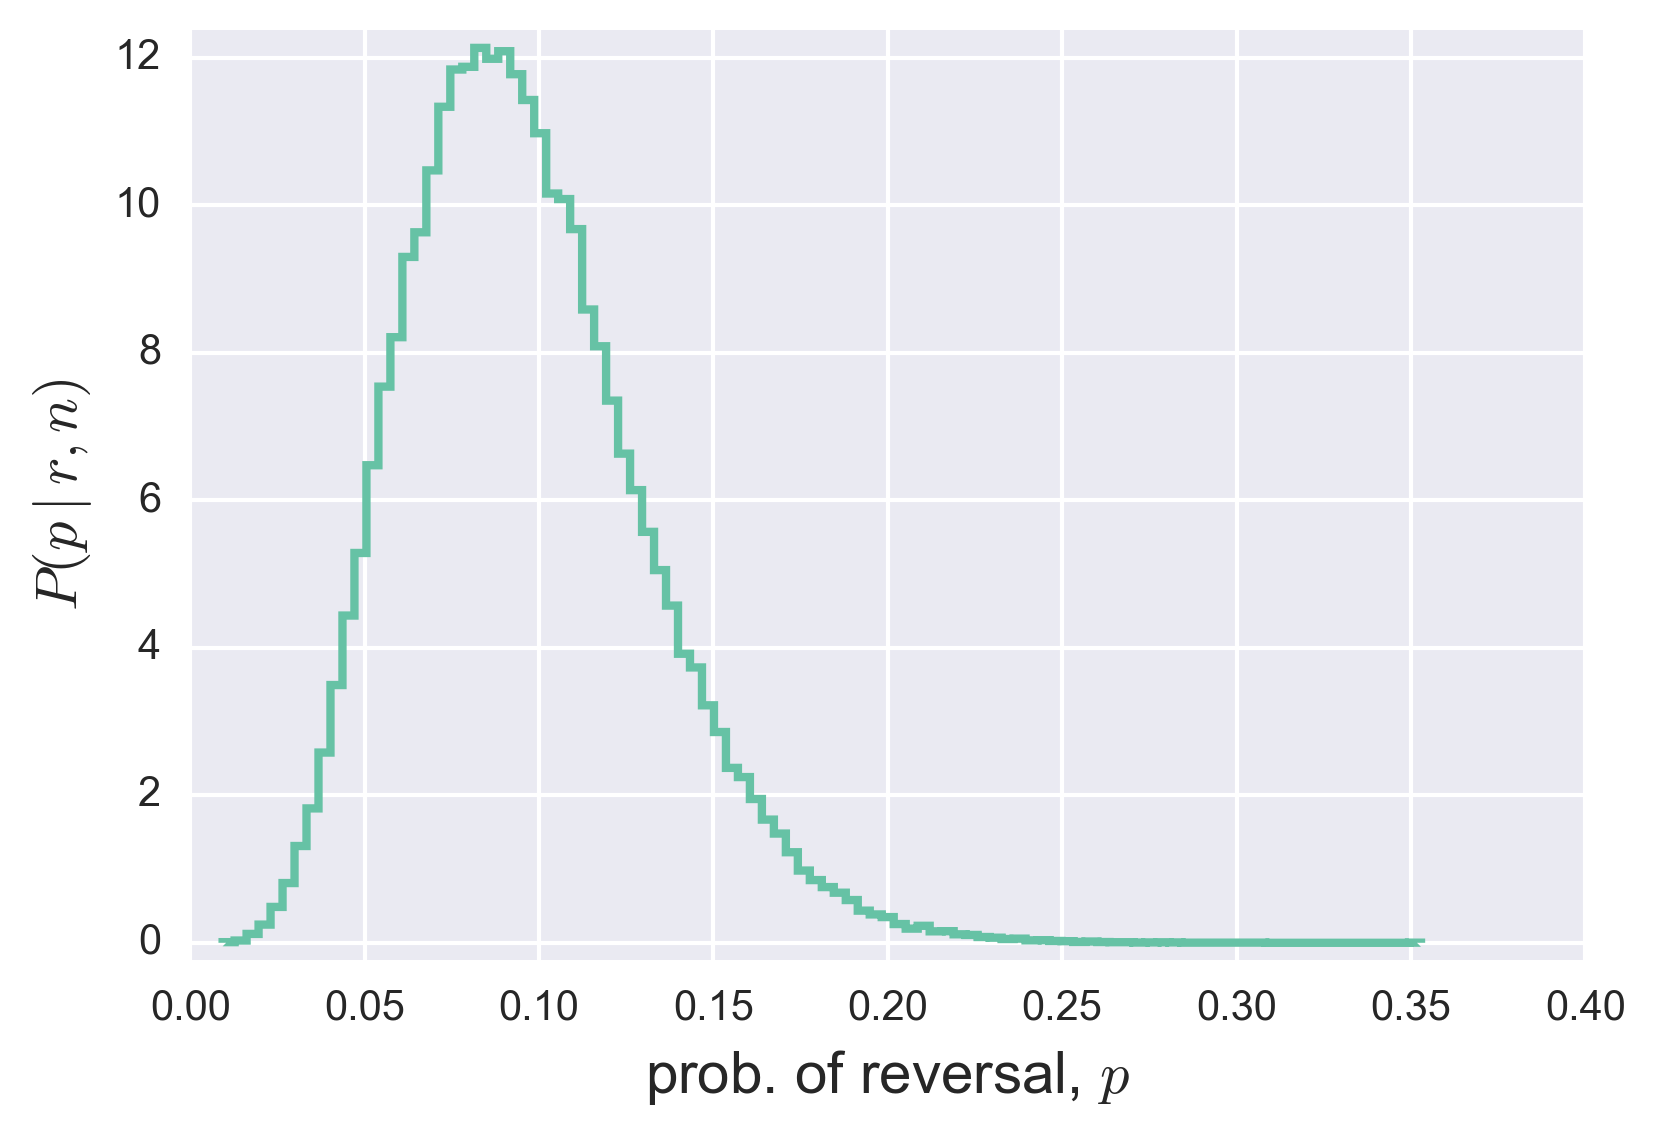

In [40]:
_ = plt.hist(df_mcmc_wt['p'], bins=100, normed=True, histtype='step', 
             linewidth=2, color=colors[0])
plt.margins(y=0.02)
plt.xlabel('prob. of reversal, $p$')
plt.ylabel(r'$P(p\mid r, n)$');

Looks pretty close to what we got analytically. Let's do all three strains and plot the histograms.

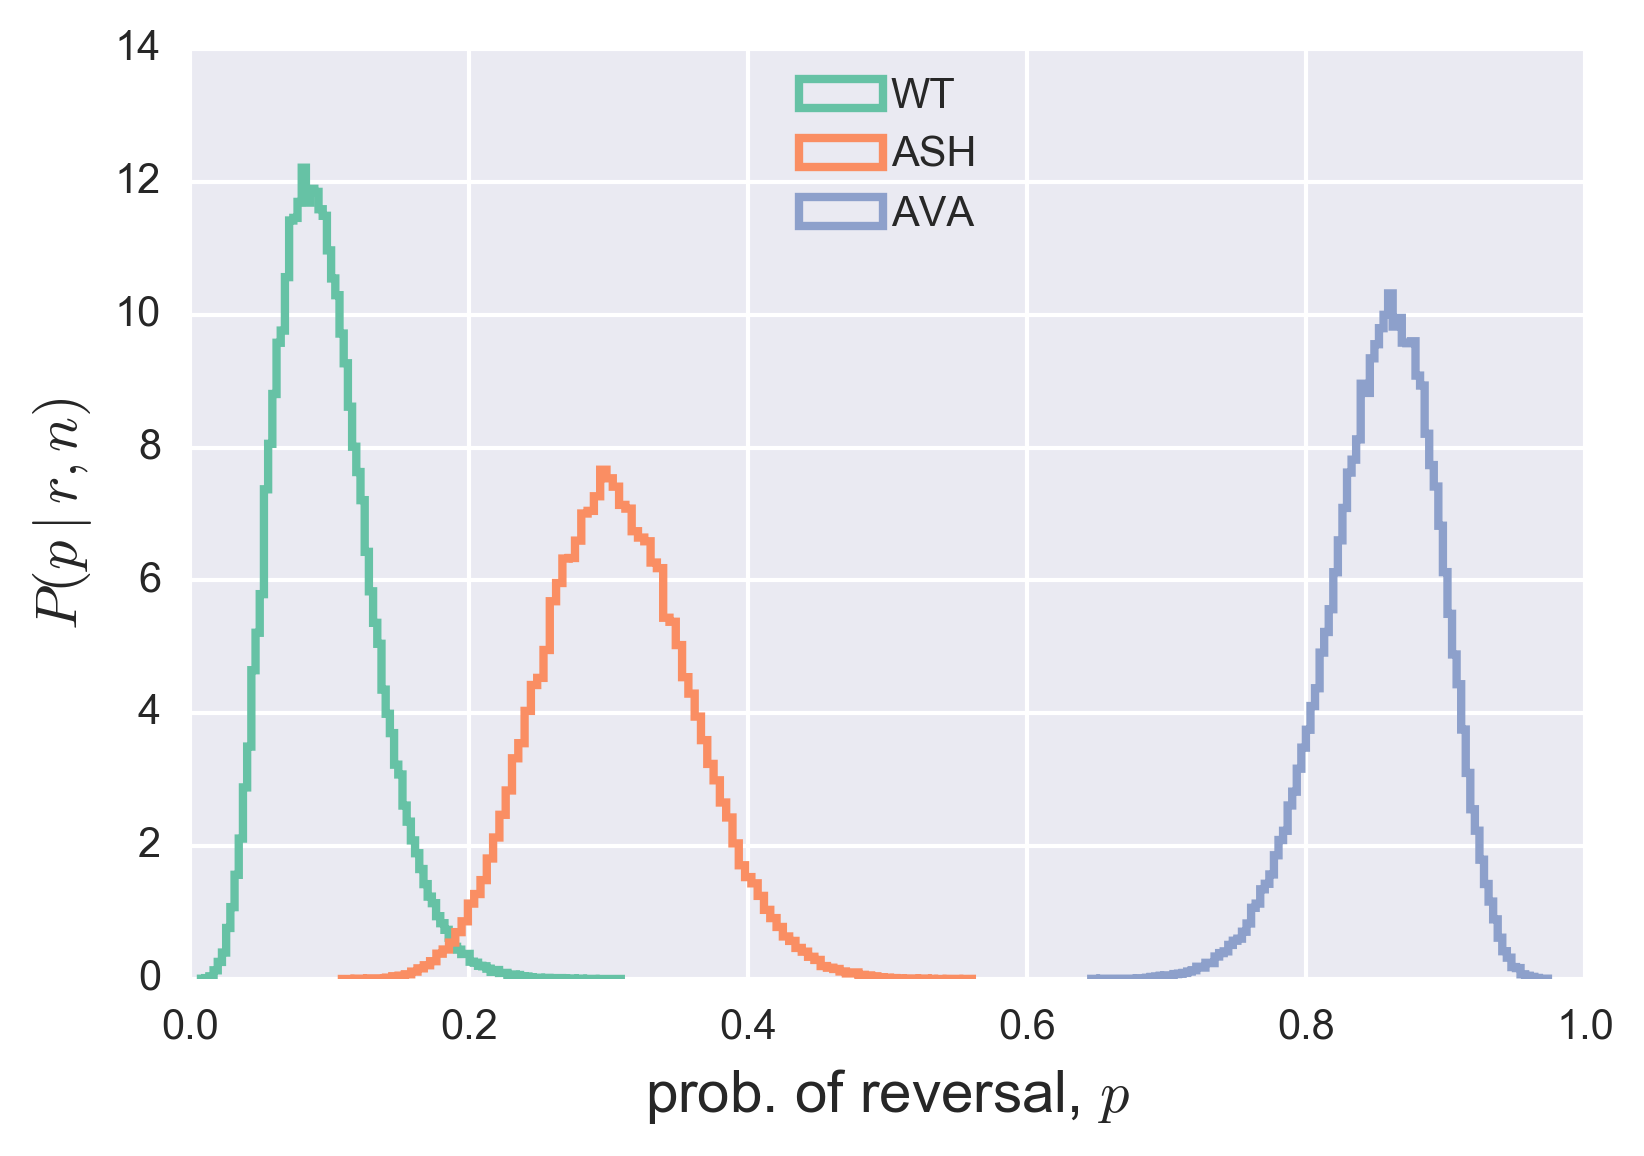

In [41]:
# DataFrame to hold result (don't care about lnprob)
df_mcmc = pd.DataFrame()

# Get samples and plot
strains = ['WT', 'ASH', 'AVA']
for i, strain in enumerate(strains):
    n, r = df.loc[df['strain']==strain, ['n', 'r']].values.flatten()
    df_mcmc[strain] = mh_sample(
        log_posterior, np.array([0.5]), np.array([0.1]), args=(n, r), 
        n_burn=500000, n_steps=500000, variable_names=['p'])['p']
    
    _ = plt.hist(df_mcmc[strain], bins=100, normed=True, 
                 histtype='step', linewidth=2, color=colors[i])

# Label axes
plt.xlabel('prob. of reversal, $p$')
plt.ylabel(r'$P(p\mid r, n)$')
plt.legend(strains, loc='upper center');

Great! Our sampler works as expected.

**c)** To check the differences, instead of doing all those nasty integrals, we just have to.... subtract the respective columns of the samples we already took!

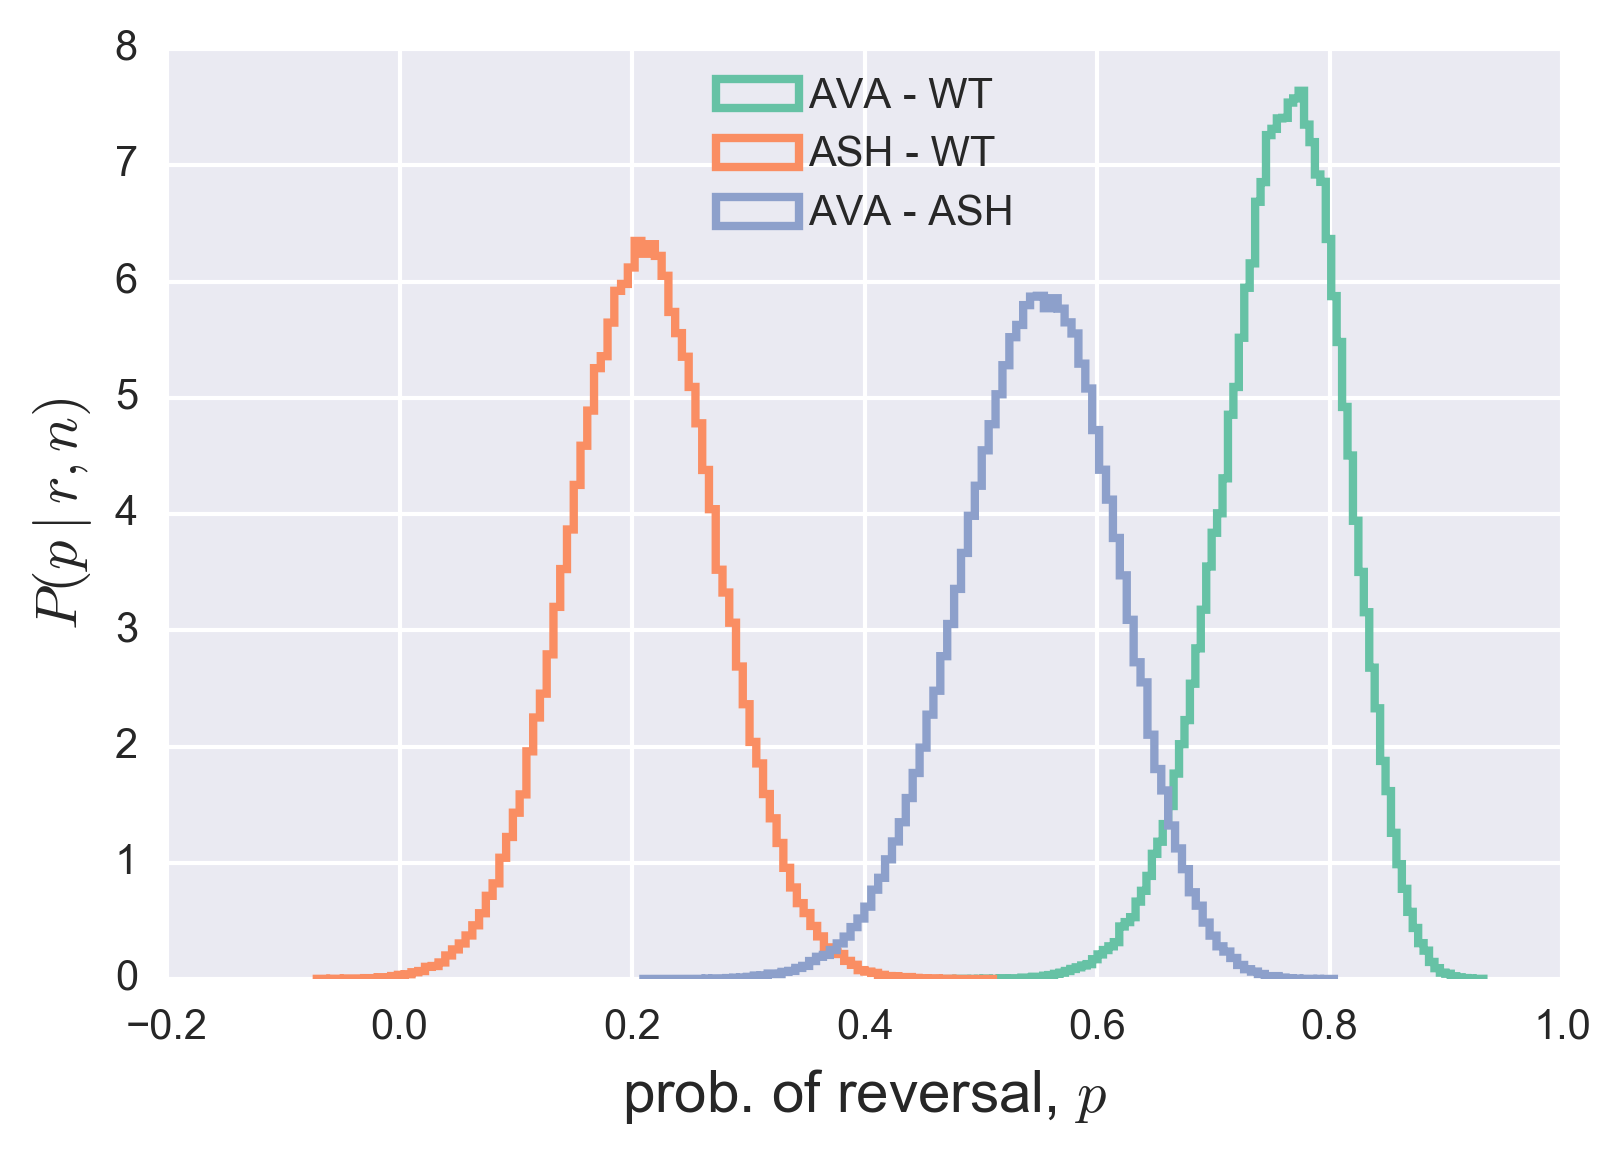

In [42]:
# Subtract samples
df_mcmc['AVA - WT'] = df_mcmc['AVA'] - df_mcmc['WT']
df_mcmc['AVA - ASH'] = df_mcmc['AVA'] - df_mcmc['ASH']
df_mcmc['ASH - WT'] = df_mcmc['ASH'] - df_mcmc['WT']

# Plot histograms
cols = ['AVA - WT', 'ASH - WT', 'AVA - ASH']  
for i, col in enumerate(cols):
    _ = plt.hist(df_mcmc[col], bins=100, normed=True, 
                 histtype='step', linewidth=2, color=colors[i])

# Label axes
plt.xlabel('prob. of reversal, $p$')
plt.ylabel(r'$P(p\mid r, n)$')
plt.legend(cols, loc='upper center');

The distributions pretty much have vanishingly small probability of being less than zero. This means that the probability of reversal for WT is less than for ASH which is less than for AVA.